In [1]:
from pcb_envs import MultiPathGridEnv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

## Env 1

In [12]:
n_agents = 4
grid_size = [15,10]
obstacles = [(3,3),(6,2), (6,3), (9,4), (9,3), (10,4), (8,9), (8,8)]
starts = [(13,8)]
goals = [(1,1)] # orig: (2,1) 
to_train = True 

In [27]:
env1 = MultiPathGridEnv(obstacles, starts, goals, grid_size=grid_size, agents_n=n_agents, train=to_train) 

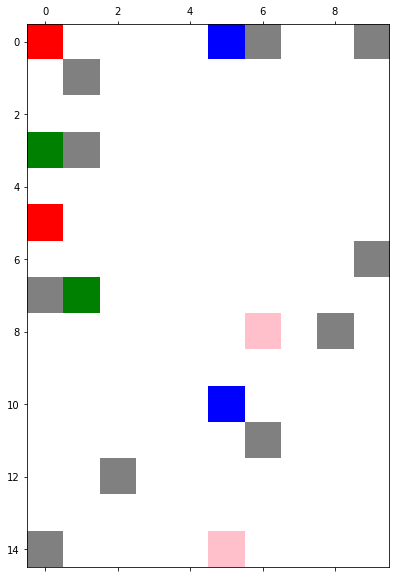

In [28]:
env1.render()

In [29]:
state = env1.step([0,4,0,7])

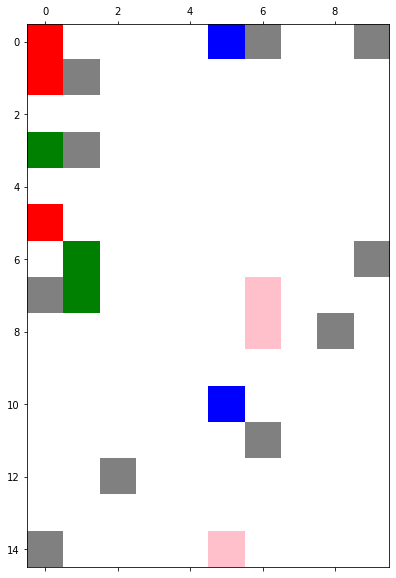

In [30]:
env1.render()

In [23]:
state # This is the state representation... 1=agent 1.1=goal of agent

(array([[ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  3.2,  0. ,  0. ,  0. ],
        [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ],
        [ 0. ,  4. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ],
        [ 0. ,  0. ,  4. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  4. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ],
        [ 0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ],
        [ 3.1,  2. ,  0. ,  1.2, -1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 3. ,  2. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 3. ,  2. ,  2.2,  0. ,  0. ,  0. ,  0. ,  0. ,  4.2, -1. ],
        [ 3. ,  2.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. , -1. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,

# Env 1 Solution

### Reply Memory
Batches of transitions are decorrelated (due to random sampling from past experience). 
Stabilizes and improved the DQN training procedure!

-- Note: We may not ever use this explicitly defined object!

In [7]:
from collections import deque

In [8]:
class PrioritizedReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        
    def add_to_buffer(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def get_importance(self, probabilities): # not really needed :-) 
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized
        
    def sample_minibatch(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
        buffer_list = list(self.buffer)
        samples = [buffer_list[i] for i in sample_indices]
        #samples = np.array(buffer_list)[sample_indices]
        #importance = self.get_importance(sample_probs[sample_indices])
        return map(list, zip(*samples)) # < TO DO: Map to Tensors instead of list??? 
    
    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

In [9]:
class ReplayBuffer(object):
    def __init__(self):
        self.buffer = []
        self.priorities = []

    def add_to_buffer(self, data):
        self.buffer.append(data)
        self.priorities.append(max(self.priorities, default=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) **priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)

        return sample_probabilities 
        
    def sample_minibatch(self,minibatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        for i in range(minibatch_length):
            random_int = np.random.randint(0, len(self.buffer)-1) 
            transition = self.buffer[random_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            rewards.append(transition[3])
            terminals.append(transition[4])
        return torch.Tensor(states), torch.Tensor(next_states), torch.Tensor(actions), torch.Tensor(rewards), torch.Tensor(terminals)

### DQN network (CNN)

In [10]:
class Q_ConvNet(nn.Module):
    """For environments of 2d image envs """
    def __init__(self, action_dim):
        super(Q_ConvNet, self).__init__()
        self.number_of_actions = action_dim
        
        self.conv1 = torch.nn.Conv2d(1, 6, 5, stride=2, padding=1) # Is padding required?
        self.conv2 = torch.nn.Conv2d(6, 12, 3, stride=1, padding=1) # Is padding required?
        
        self.fcv1 = nn.Linear(336, 248) # Value stream... 
        self.fcv2 = nn.Linear(248, 1)
        
        self.fca1 = nn.Linear(336, 248)
        self.fca2 = nn.Linear(248, self.number_of_actions)
        

    def forward(self, state):
        state = F.relu(self.conv1(state))
        state = F.relu(self.conv2(state))
        state = state.view(state.size(0), -1) 
        
        v = F.relu(self.fcv1(state)) # Value stream... 
        v = self.fcv2(v)
        
        a = F.relu(self.fca1(state)) # Advantage stream... 
        a = self.fca2(a)
        
        q = v + a-a.mean()
        
        return q 

In [11]:
state_dim = grid_size[0]*grid_size[1]
action_dim = 8

### DQN agent

In [12]:
class DQNAgent(object):
    def __init__(self, state_dim, action_dim):
        self.qnet = Q_ConvNet(action_dim)
        self.qnet_optim = torch.optim.Adam(self.qnet.parameters(), lr=0.001) # Optimiser to optimize our qnet parameters with learning rate 0.01
        self.discount_factor = 0.99 
        self.MSELoss_function = nn.MSELoss() # Takes input (required_grad=True) and output, then we can backprop with respect to this cost function to calcualte loss :) 
        self.memory = PrioritizedReplayBuffer(1000)
        self.network_loss_history = []
        
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon: 
            return random.sample(env1.action_space,1)[0] 
        else: 
            network_output_to_numpy = self.qnet(state).cpu().data.numpy()
            max_value = np.max(network_output_to_numpy)
            max_indices = np.nonzero(network_output_to_numpy == max_value)[0]
            policy_action = np.random.choice(max_indices) 
            return policy_action  
    
    def policy_action(self, state):
        network_output_to_numpy = self.qnet(state).cpu().data.numpy()
        max_value = np.max(network_output_to_numpy)
        max_indices = np.nonzero(network_output_to_numpy == max_value)[0]
        policy_action = np.random.choice(max_indices) 
        return policy_action  
    
    # Update Q Network based on our observation: 
    # TIP: Look at the Bellman equation :) 
    def update_Q_Network(self, state, next_state, action, reward, terminal):
        qsa = torch.gather(self.qnet(state), dim=1, index=action.long()) # Q(s,a) (Value for selecting action given current Q-policy)
        qsa_next_actions = self.qnet(next_state)
        qsa_next_action, _ = torch.max(qsa_next_actions, dim=1, keepdim=True) # AGAIN is this fair???? 
        not_terminal = 1-terminal # <- If it is not terminal (negation) then we will apply additional discount value: 
        reward = reward.resize_(not_terminal.size()) # <<<-- But what made it out of shape to (batch_size,1,1)
        qsa_next_target = reward + not_terminal * self.discount_factor * qsa_next_action
        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach()) # ** Why detatch qsa_next_target so that no gradients pass it?
        self.network_loss_history.append(q_network_loss.double())
        self.qnet_optim.zero_grad() # Restard gradients for optimisation 
        q_network_loss.backward() # <- Calculate gradient... ** But what were we tracking??** 
        self.qnet_optim.step()  # Take a step according the gradient calculated above??** 🤔
        
    def update(self, update_rate):
        for i in range(update_rate):
            states, next_states, actions, rewards, terminals = self.memory.sample_minibatch(120)
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals) 
            self.update_Q_Network(states, next_states, actions, rewards, terminals)

In [13]:
np.array([[2,3],[4,3]]).reshape(1,2,2).shape

(1, 2, 2)

### Training

In [14]:
dqn_agent = DQNAgent(state_dim, action_dim)
reward_sums_list = []
epsilon_history = []

In [15]:
def train_agent(agent):
    N = 100000
    max_time_steps = 3000
    epsilon = 0.6
    decay = 0.9999
    min_epsilon = 0.1
    for episode in range(N):
        reward_sum = 0
        state = env1.reset()
        epsilon = max(min_epsilon, epsilon*decay)
        epsilon_history.append(epsilon)
        for i in range(max_time_steps):
            chosen_actions = []
            action = agent.epsilon_greedy_action(torch.from_numpy(state).reshape(1,1,15,10).float(), epsilon)
            if type(action) is not list:
                action = [action]
            next_state, reward, terminal = env1.step(action)
            reward_sum += reward[0]
            agent.memory.add_to_buffer((state.reshape(1,15,10), next_state.reshape(1,15,10), action, [reward], [terminal]))
            state = next_state
            #env1.render()
            if terminal:
                clear_output(wait=False)
                display('Current episode: ' + str(episode))
                reward_sums_list.append(reward_sum)
                reward_sum = 0
                break
        if episode !=0:
            agent.update(40)

In [16]:
train_agent(dqn_agent) 

'Current episode: 105'

KeyboardInterrupt: 

## Visualise training 

In [17]:
for n, ep_rewards in enumerate(reward_sums_list):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    col = "r" if (n%2==0) else "b"
    plt.plot(x, avgs, color=col, label=n)
    
plt.title("Prioritized Replay performance")
plt.xlabel("Episode")
plt.ylabel("Last 100 episode average rewards")
plt.legend()

TypeError: object of type 'numpy.float64' has no len()

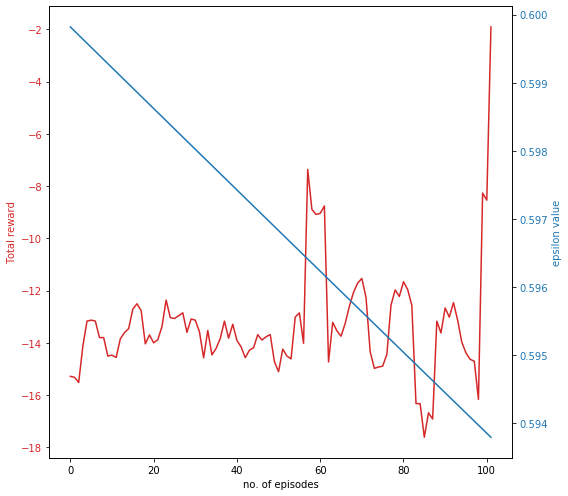

In [26]:
fig, ax1 = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(8)
color = 'tab:red'
ax1.set_xlabel('no. of episodes')
ax1.set_ylabel('Total reward', color=color)
cumsum_vec = np.cumsum(np.insert(reward_sums_list, 0, 0)) 
ma_vec = (cumsum_vec[5:] - cumsum_vec[:-5]) / 5 # <<-- 100 instead of 5
ax1.plot(range(0,len(ma_vec)), ma_vec, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('epsilon value', color=color)
cumsum_vec_e = np.cumsum(np.insert(epsilon_history, 0, 0)) 
ma_vec_e = (cumsum_vec_e[5:] - cumsum_vec_e[:-5]) / 5
ax2.plot(range(0,len(ma_vec_e)), ma_vec_e, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
print("Max reward sum received: ", np.max(reward_sums_list))

In [ ]:
plt.figure(figsize=(15,8))
plt.title("MSE error per update (of batch updates)")
plt.plot(dqn_agent.network_loss_history) # <<-- MSE 

## Learnt Policy 

In [ ]:
def run_agent(agent):
    max_time_steps = 5000
    reward_sum = 0
    state = env1.reset().flatten()
    for i in range(max_time_steps):
        chosen_actions = []
        action = agent.policy_action(torch.from_numpy(state.flatten()).float())
        next_state, reward, terminal = env1.step([action])
        next_state = next_state.flatten() 
        reward_sum += reward[0]
        state = next_state
        env1.render()
        if terminal:
            time.sleep(0.2)
            print("Reward sum is: ", reward_sum)
            state = env1.reset().flatten()
            reward_sum = 0
            break

In [ ]:
run_agent(dqn_agent)

## Interpratability test 

In [ ]:
env1.reset()
env1.step([0])
state = torch.from_numpy(env1.step([0])[0].flatten()).float()

In [ ]:
state

In [ ]:
dqn_agent.qnet(state)

## Save model parameters 

In [ ]:
torch.save(model.state_dict(), '/models')

## Generalisation test 

In [ ]:
env1_mod1 = MultiPathBoardEnv(obstacles, starts, [(7,4)], grid_size=grid_size, agents_n=n_agents) 
reward_sums_list = []

In [ ]:
env1_mod1.render()

In [ ]:
def run_agent():
    N = 2
    max_time_steps = 1000
    for episode in range(N):
        reward_sum = 0
        state = env1_mod1.reset().flatten()
        for i in range(max_time_steps):
            chosen_actions = []
            action = dqn_agent.policy_action(torch.from_numpy(state.flatten()).float())
            next_state, reward, terminal = env1_mod1.step([action])
            next_state = next_state.flatten() 
            reward_sum += reward[0]
            state = next_state
            env1_mod1.render()
            if terminal:
                time.sleep(0.2)
                reward_sums_list.append(reward_sum)
                state = env1_mod1.reset().flatten()
                reward_sum = 0
                break

In [ ]:
run_agent()

In [ ]:
plt.plot(reward_sums_list)

In [ ]:
state = env1.step([2])

In [ ]:
state[0]

In [ ]:
test_list = []
for i in range(0,15):
    test_list.append(i)

In [ ]:
test_set = set(test_list)

In [ ]:
test_sample = random.sample(test_set,4)
test_sample

In [ ]:
test_set.difference(test_sample)

In [ ]:
action_space = list(range(0,8))

In [ ]:
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    coord_set.add((i,j)) # Do a pythonic list comprehension :) 

In [ ]:
[(i,j) for i in range(15) for j in range(10)]

In [ ]:
if 1%2 is not 1:
    print("Hello")